## План
      1. Загрузим и подготовим данные.
      2. Обучим разные модели. Для каждой попробуем различные гипепараметеры.
      3. Проанализируем скорость работы и качество моделей.

# 1. Подготовка данных

In [2]:
# импорты
import pandas as pd
import time
import numpy as np
import lightgbm as lgb
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OrdinalEncoder 
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

In [3]:
# выгрузим данные
data = pd.read_csv('/datasets/autos.csv')
display(data.head())
data.info()

# заменим NAN странные "0" месяцы
strange_column = data['RegistrationMonth']
print(data['RegistrationMonth'].value_counts())
data.loc[data['RegistrationMonth'] == 0, 'RegistrationMonth'] = np.nan

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
DateCrawled          354369 non-null object
Price                354369 non-null int64
VehicleType          316879 non-null object
RegistrationYear     354369 non-null int64
Gearbox              334536 non-null object
Power                354369 non-null int64
Model                334664 non-null object
Kilometer            354369 non-null int64
RegistrationMonth    354369 non-null int64
FuelType             321474 non-null object
Brand                354369 non-null object
NotRepaired          283215 non-null object
DateCreated          354369 non-null object
NumberOfPictures     354369 non-null int64
PostalCode           354369 non-null int64
LastSeen             354369 non-null object
dtypes: int64(7), object(9)
memory usage: 43.3+ MB
0     37352
3     34373
6     31508
4     29270
5     29153
7     27213
10    26099
12    24289
11    24186
9     23813
1     23219
8     226

In [4]:
# избавимся от NaN
data.dropna(inplace = True)
# удалим столбцы с почтовыми игдексами и количестовм фоток (т.к они нас не интересуют и на стоимость не влияют)
data.drop(['PostalCode','NumberOfPictures','DateCrawled', 'DateCreated', 'LastSeen'], axis = 1, inplace = True)

# Выделим списки с именами столбцов фитч и категориальных фитч
name_features = data.drop('Price', axis=1).columns.tolist()
name_object_features = data.select_dtypes(include=['object']).columns.tolist()


print(name_object_features)

['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']


In [5]:
# Уберем аномалии  и дубликаты
data = data.query('Price > 500')
data = data.query('Power < 400')
data = data.query('RegistrationYear > 1970')
data.drop_duplicates(inplace = True)
data.duplicated().sum()

0

In [6]:
# применим Encoder для дальнейшего использования рандомного леса (one-hot encoding не подхолит, 
# поскольку угрожает весить 65 ГБ, что недопустимо в рамках этого проекта )
encoder = OrdinalEncoder() 

# сохраним в отдельный датасет 
data_encoder = pd.DataFrame(encoder.fit_transform(data),columns = data.columns)

In [7]:
# выделим фитчи для 2 датасетов
features = data_encoder.loc[:,name_features]
target = data_encoder['Price']

In [8]:
# заменим все столбцы с 'object' на 'category'
for c in name_object_features:
    features.loc[:,c] = features.loc[:,c].astype('category')
    
name_categorical_features = name_object_features

In [9]:
# разделим для градиентного бустинга на 3 выборки по скольку он использует валидационную
features_train, features_valid, features_test = np.split(features.sample(frac=1, random_state = 12345), 
                                                            [int(.6*len(features)), int(.8*len(features))])
target_train, target_valid, target_test = np.split(target.sample(frac=1, random_state = 12345), 
                                                            [int(.6*len(target)), int(.8*len(target))])

# для рандомного леса разделим на 2
features_train_encoder, features_test_encoder, target_train_encoder, target_test_encoder = train_test_split(
    features,target, test_size=0.25, random_state=12345)

## Вывод
Мы видим довольно объемную выборку на 350 000 строк и 16 столбцов. После недолгих раздумий мы удаляем столбцы 'PostalCode' и 'NumberOfPictures', по-скольку те не влияют на итоговую стоимость авто (количество фоток влияет на на продавемость? Да! Но это уже другой анализ). Так-же можно заметить аномалию в перовой же строчке таблицы в столбце RegistrationMonth: избавляемся с помощью амены на NaN. Далее мы дропаем все NaN в таблице, чтобы воспользоваться OrdinalEncoder для, чтобы избавится от символьных переменных. Переводим все 'object' в 'category' для дальнейшего бустинга. Используя разные сплиты формируем выборки для 2 будующих моделей.

# 2. Обучение моделей

In [10]:
name_features

['VehicleType',
 'RegistrationYear',
 'Gearbox',
 'Power',
 'Model',
 'Kilometer',
 'RegistrationMonth',
 'FuelType',
 'Brand',
 'NotRepaired']

In [356]:
%%time

# сформируем датасеты train и valid
gbm_train = lgb.Dataset(features_train,label = target_train, feature_name = name_features, 
                        categorical_feature = name_categorical_features,free_raw_data=False)

gbm_valid = lgb.Dataset(features_valid,label = target_valid, feature_name = name_features, 
                        categorical_feature = name_categorical_features,free_raw_data=False)

# в параметрах укажем необходимое + оценочную метрику (благо есть rmse)
param = {'num_leaves': 31}
param['metric'] = 'rmse'

# обучим с 200 итрациями с выводм по 20 и ранним торможением после 20 итераций нероста 
num_round = 200
lgbm = lgb.train(param, gbm_train, num_round,valid_sets = gbm_valid, verbose_eval = 20, 
          early_stopping_rounds = 20,categorical_feature = name_categorical_features)

Training until validation scores don't improve for 20 rounds
[20]	valid_0's rmse: 336.661
[40]	valid_0's rmse: 288.98
[60]	valid_0's rmse: 281.332
[80]	valid_0's rmse: 278.503
[100]	valid_0's rmse: 276.572
[120]	valid_0's rmse: 275.342
[140]	valid_0's rmse: 274.225
[160]	valid_0's rmse: 273.329
[180]	valid_0's rmse: 272.566
[200]	valid_0's rmse: 272.028
Did not meet early stopping. Best iteration is:
[200]	valid_0's rmse: 272.028
CPU times: user 11.9 s, sys: 109 ms, total: 12 s
Wall time: 12.1 s


In [357]:
%%time

# обучим лес с пмощью GridSearchCV 
state = 12345
rfg = RandomForestRegressor(random_state = state)
forest_parametrs = { 'n_estimators': range (10, 31, 10),
              'max_depth': range (1,5, 2)}

# в скорер запишем MSE а в вывод лучшего RMSE
scorer = make_scorer(mean_squared_error)
grid_rfg = GridSearchCV(rfg, forest_parametrs, cv = 3, scoring = scorer)
grid_rfg.fit(features_train_encoder, target_train_encoder)

# выведем лучший результат 
print('The parameters combination that would give best RMSE is : ')
print(grid_rfg.best_params_)
print('The RMSE accuracy achieved after parameter tuning via grid search is : ', np.sqrt(grid_rfg.best_score_))

The parameters combination that would give best RMSE is : 
{'max_depth': 1, 'n_estimators': 10}
The RMSE accuracy achieved after parameter tuning via grid search is :  642.8043584503027
CPU times: user 17.9 s, sys: 240 ms, total: 18.1 s
Wall time: 18.1 s


## Вывод
Как мы можем заметить, градиентный бустинг (в равных условиях) значительно быстрее и точнее рандомного леса. 

# 3. Анализ моделей

276.1391047781168
638.9190381337171


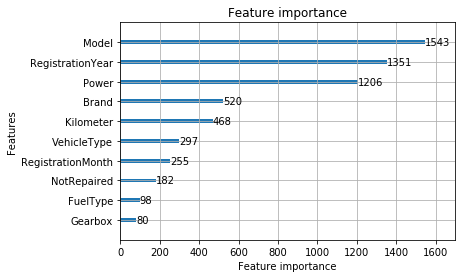

In [358]:
# посмотрим на тестовой выборке для градиентного бустинга
lgbm_predicted = lgbm.predict(features_test)
print(np.sqrt(mean_squared_error(lgbm_predicted, target_test)))

# посмотрим на тестовой выборке для рандомного леса
model = RandomForestRegressor(**grid_clf.best_params_, random_state=12345)
model.fit(features_train_encoder, target_train_encoder)
rfg_predicted = model.predict(features_test_encoder)
print(np.sqrt(mean_squared_error(rfg_predicted, target_test_encoder)))


# воспользуемся для построения функции важности параметров 
lgb.plot_importance(lgbm)

# хотел использвать это но здесь нет этой бибилиотеки, а на попытку установки получил ошибку)
#fs = FeatureSelector(data = features, labels = target)
#fs.plot_feature_importances(threshold = 0.95)

## Вывод
Как мы видим точность бустинга выше почти в 2 раза (по метрике RMSE), скорость также намного выше у бустинга. Из чего мы можем сделать вывод о том , что градиентный бустинг предпочтительнее (особенно на больших выборках 1 млн + строк) нежели другие модели ввиду своего удобства (LightGBM способен работать и с категориальными признаками в 8 раз быстрее чем при кодировании их с помощью прямого кодирования) , скорости и точности предсказаний.